<a href="https://colab.research.google.com/github/jing-yu-lim/NST-Content-Image-Reconstruction-with-DEIT-Transformer/blob/main/DEIT_Content_Regen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NST Content Image from Noise Image using DEIT


change

In [ ]:
# DeiT is built on top of timm. BUT version 0.3.2 does not work with pytorch 1.9; use latest timm
!pip install timm==0.4.12

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
import timm
import torchvision
import torchvision.transforms as T

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

deit=torch.hub.load('facebookresearch/deit:main','deit_base_patch16_224',pretrained=True)

for param in deit.parameters():
    param.requires_grad=False
    param.retain_grad=True

deit.to(device)
deit.eval()

In [ ]:
def load_image(url,max_size=400,shape=None,is_url=True, is_deit=False):
    
    if is_url:
        image=Image.open(requests.get(url,stream=True).raw)
    else:
        image=Image.open(url)

    #use deit transform if model is deit   

    transform=T.Compose([
                        T.Resize(256, interpolation=3),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(IMAGENET_DEFAULT_MEAN,IMAGENET_DEFAULT_STD),                         
                        ])
    
    if image.mode !='RGB':
        image=image.convert('RGB')

    image = transform(image).unsqueeze(0)

    return image

In [ ]:
c_url='https://pbs.twimg.com/profile_images/1416443682157473795/dGtFbtht_400x400.jpg'
content_t=load_image(c_url,is_deit=True).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
def get_deit_features(im,model=deit):
    block_features=[]

    hooks=[
           model.blocks[0].register_forward_hook(
               lambda self, input, output: block_features.append(output)
           )
    ]

    outputs=model(im)
    for hook in hooks:
        hook.remove()
    return block_features[0]


In [ ]:
#content feature from deit
c_x_features=get_deit_features(content_t,deit) 

Text(0.5, 1.0, 'Generated Image')

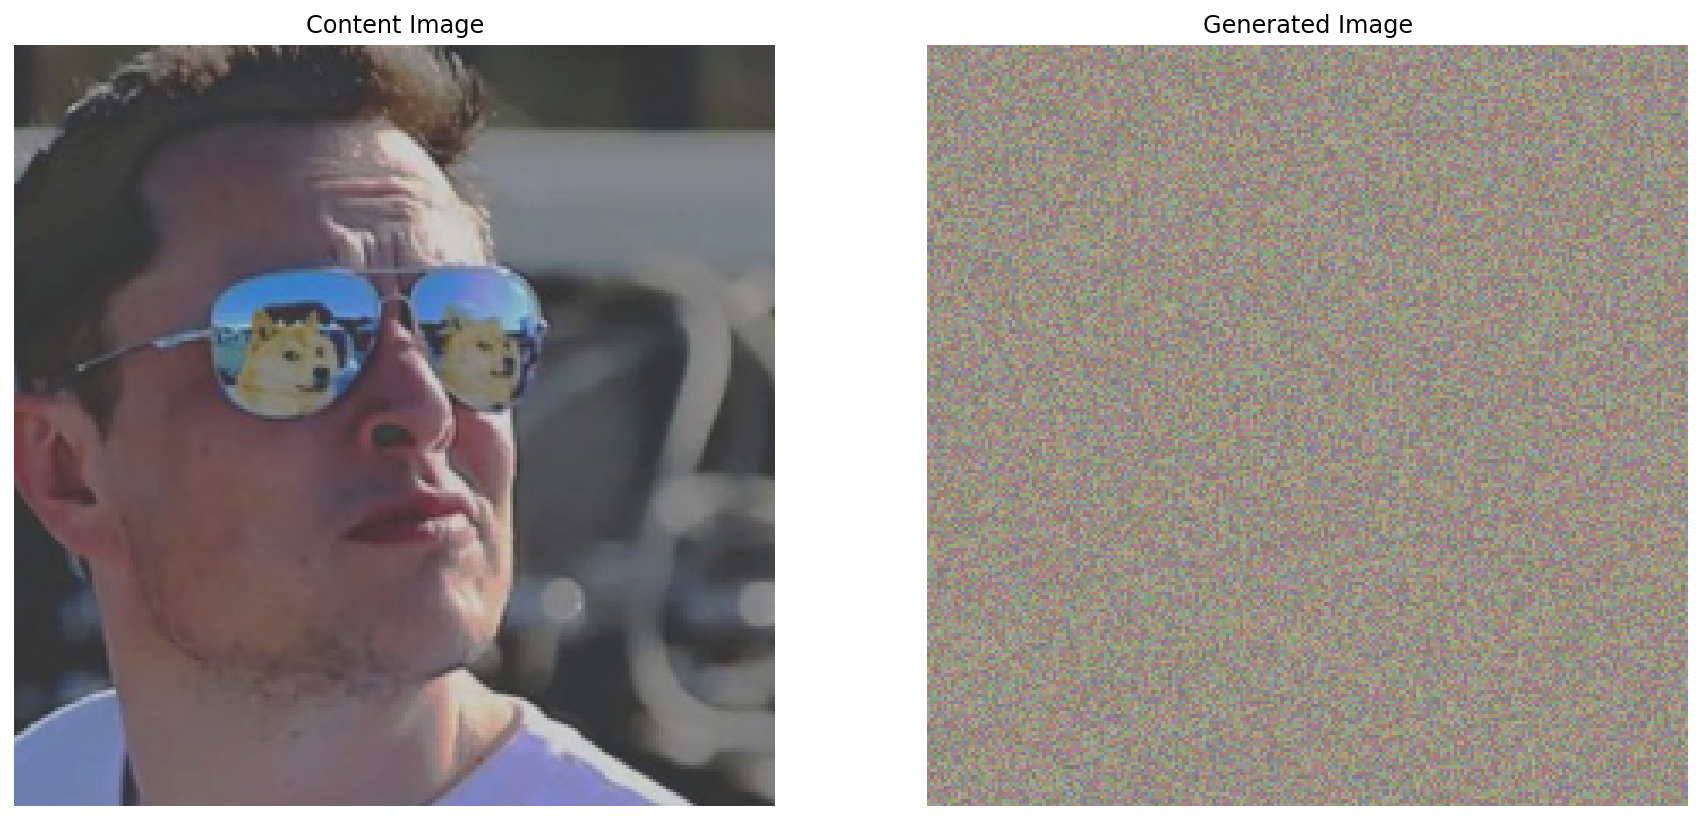

In [ ]:
#initialise generated image with noise
gen_image=(torch.rand_like(content_t)).requires_grad_(True).to(device)

fig,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].axis('off')
ax[0].imshow(im_convert(content_t))
ax[0].set_title('Content Image')

ax[1].axis('off')
ax[1].imshow(im_convert(gen_image))
ax[1].set_title('Generated Image')

plt.savefig('/content/pics/content_vs_gen.jpg') #CALL SAVEFIG BEFORE PLT.SHOW
plt.show()

Hyparameters

In [ ]:
overall_content_weight=5e10

steps = 10000
optimizer=torch.optim.Adam([gen_image],lr=0.05)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95,verbose=False)
lr_epoch=250 #how often to update the LR

In [ ]:
for i in range(steps):

    g_x_features=get_deit_features(gen_image)

    total_content_cost=torch.mean((c_x_features-g_x_features)**2)
    
    total_cost=overall_content_weight*total_content_cost 
    
    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

    if i%9==0:
        print('Total loss:',total_cost)

    if i%lr_epoch==0:
        #print the current learning rate
        scheduler.step() 
        l_rate=optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {l_rate:.7f}')

    if i%500==0:
        print('Step: ',i+1)
        plt.imshow(im_convert(gen_image))
        plt.axis('off')
        plt.savefig(f'/content/pics/gen_im_{i}.jpg')
        plt.show()
    

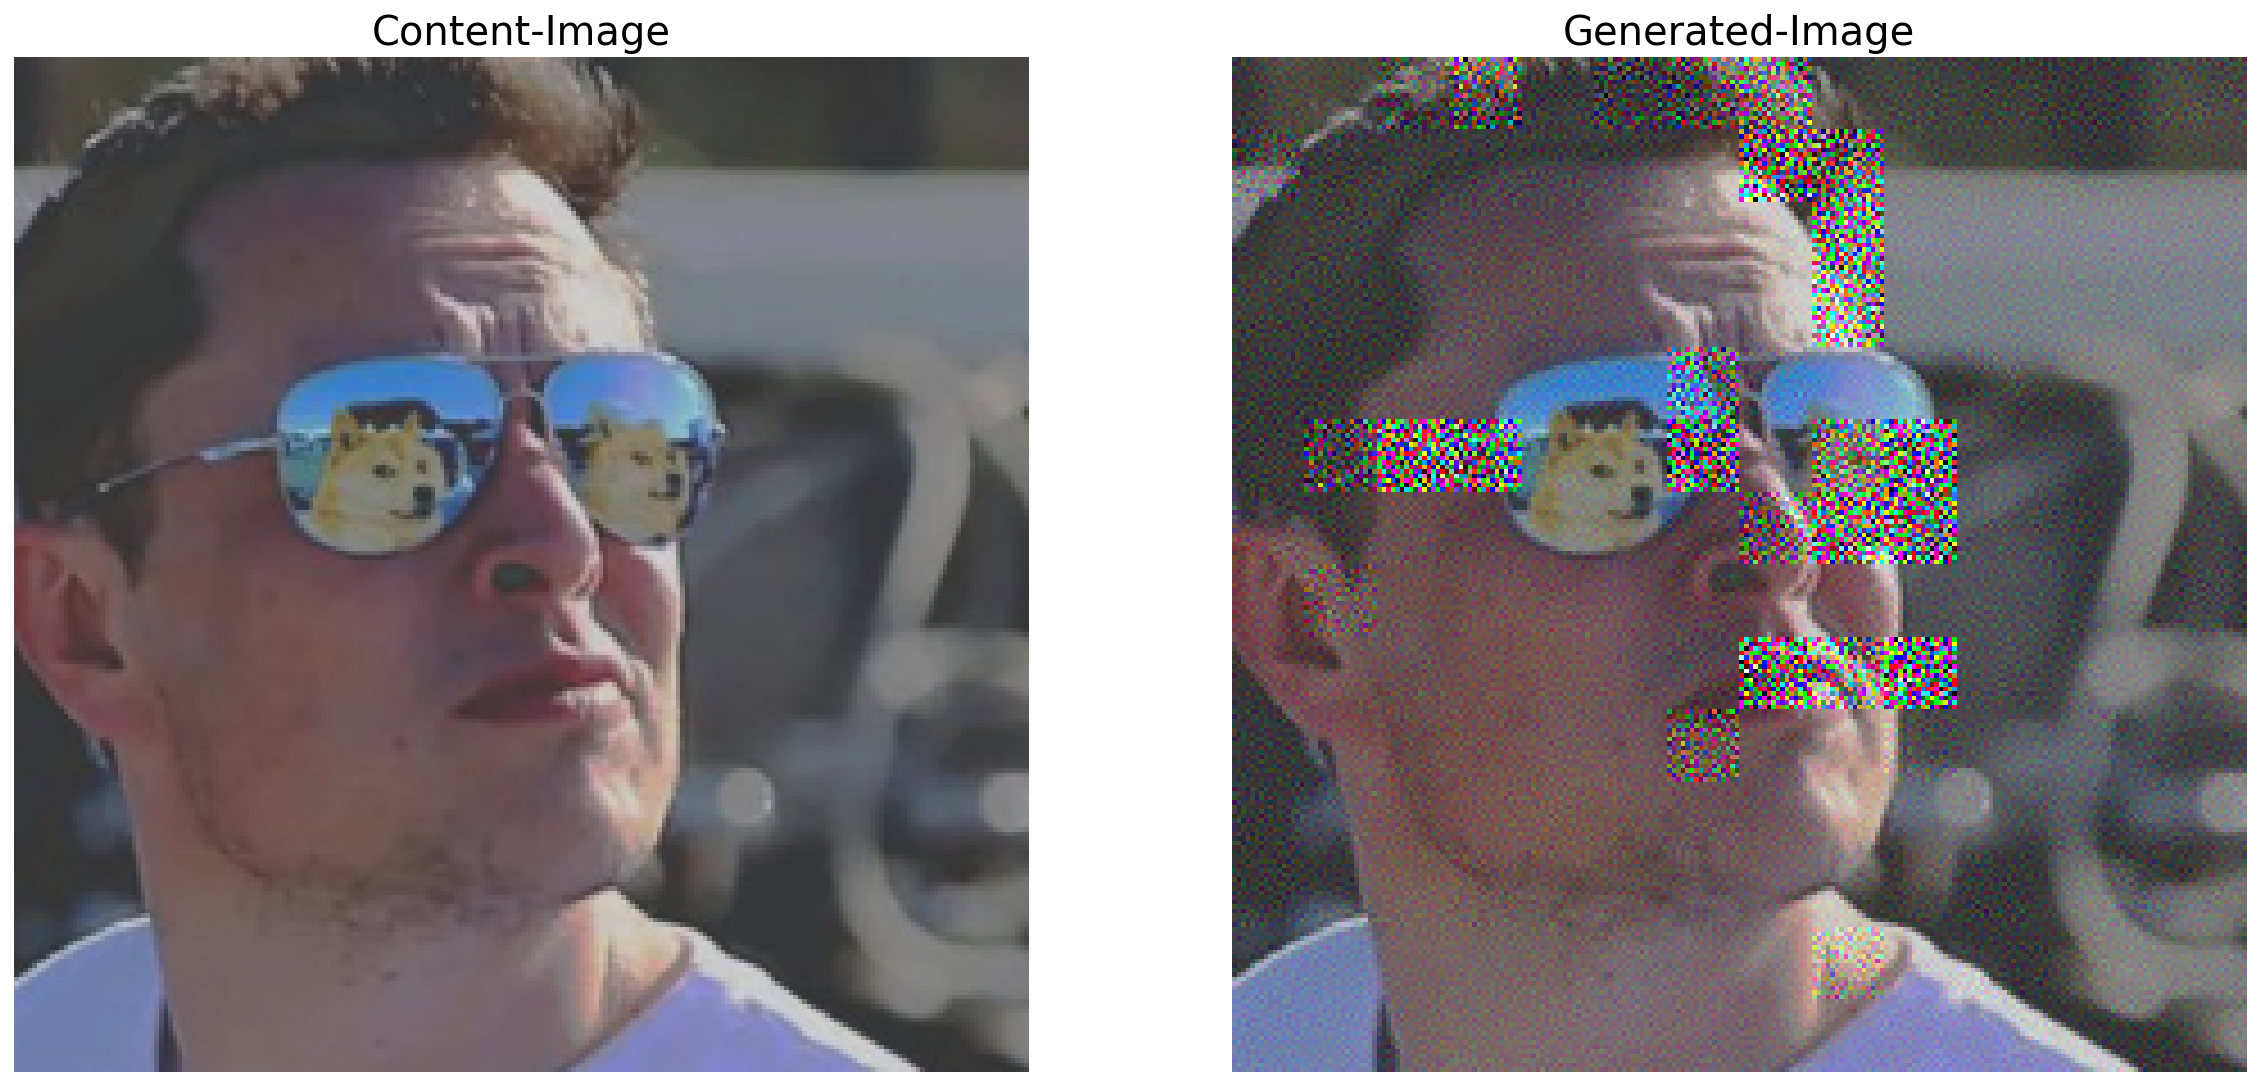

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_t))
ax1.set_title("Content-Image",fontsize = 20)
ax1.axis('off')

ax2.imshow(im_convert(gen_image))
ax2.set_title("Generated-Image", fontsize = 20)
ax2.axis('off')

plt.savefig('/content/pics/content_gen_overall.jpg') #CALL SAVEFIG BEFORE PLT.SHOW
plt.show()

In [ ]:
!zip -r /content/content_regen.zip /content/pics

updating: content/elon1/ (stored 0%)
updating: content/elon1/Elon4500.jpg (deflated 4%)
updating: content/elon1/Elon5500.jpg (deflated 4%)
updating: content/elon1/Elon8500.jpg (deflated 4%)
updating: content/elon1/Elon4000.jpg (deflated 4%)
updating: content/elon1/Elon500.jpg (deflated 3%)
updating: content/elon1/Elon7500.jpg (deflated 4%)
updating: content/elon1/Elon2000.jpg (deflated 4%)
updating: content/elon1/Elon12000.jpg (deflated 4%)
updating: content/elon1/Elon3500.jpg (deflated 4%)
updating: content/elon1/Elon0.jpg (deflated 4%)
updating: content/elon1/Elon9000.jpg (deflated 4%)
updating: content/elon1/elon_overall_12500.jpg (deflated 4%)
updating: content/elon1/Elon11500.jpg (deflated 4%)
updating: content/elon1/Elon10500.jpg (deflated 4%)
updating: content/elon1/Elon6500.jpg (deflated 4%)
updating: content/elon1/Elon12500.jpg (deflated 4%)
updating: content/elon1/Elon1000.jpg (deflated 3%)
updating: content/elon1/Elon3000.jpg (deflated 4%)
updating: content/elon1/Elon8000.jp

In [ ]:
from google.colab import files
files.download('/content/content_regen.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>